In [120]:
import numpy as np 
import pandas as pd 
import os
import matplotlib.pyplot as plt
import seaborn as sns
import math
import time
import cv2
from sklearn import metrics
import gc
import tensorflow as tf
#from tensorflow import keras
from keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras import models
from keras.layers import Dense, Dropout, Flatten, BatchNormalization, Activation
from keras.layers import Conv2D, MaxPool2D

#from torch
import torch
from torch.utils.data import TensorDataset, DataLoader,Dataset, random_split


In [19]:
# Creating paths for train and test data
sample_df = pd.read_csv("/kaggle/input/histopathologic-cancer-detection/sample_submission.csv")
trained_df = pd.read_csv("/kaggle/input/histopathologic-cancer-detection/train_labels.csv")
train_path = "/kaggle/input/histopathologic-cancer-detection/train" 
test_path = "/kaggle/input/histopathologic-cancer-detection/test"

In [20]:
trained_df.head()

,id,label
0,f38a6374c348f90b587e046aac6079959adf3835,0
1,c18f2d887b7ae4f6742ee445113fa1aef383ed77,1
2,755db6279dae599ebb4d39a9123cce439965282d,0
3,bc3f0c64fb968ff4a8bd33af6971ecae77c75e08,0
4,068aba587a4950175d04c680d38943fd488d6a9d,0


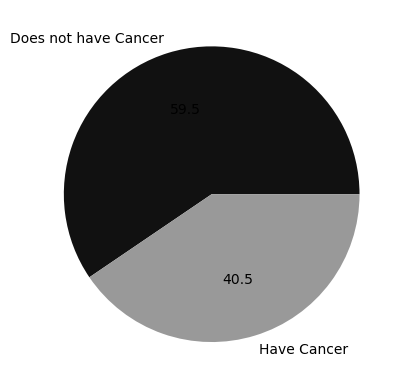

In [25]:
label_count = trained_df.label.value_counts()
#Show the data of who has cancer and who doesn't
%matplotlib inline
plt.pie(label_count, labels=['Does not have Cancer', 'Have Cancer'],
        autopct='%1.1f', colors=['#111111','#999999'])
plt.show()

In [26]:
gc.collect()

10305

In [68]:
from glob import glob

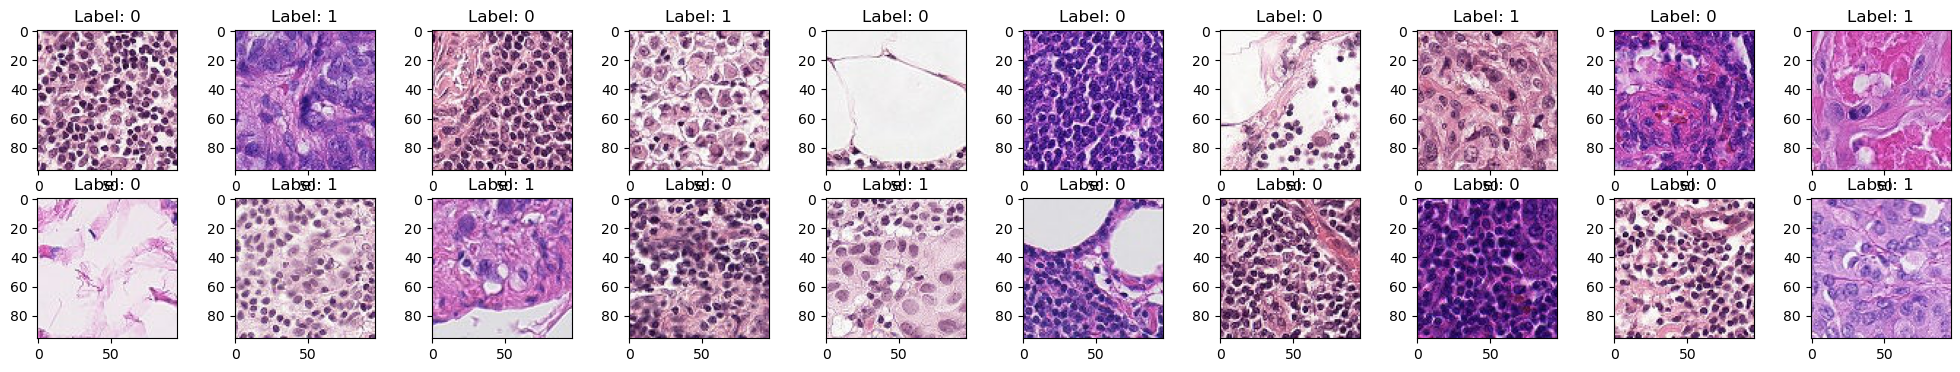

In [75]:
fig = plt.figure(figsize=(25, 4))
pathdata = "/kaggle/input/histopathologic-cancer-detection/train"
train_imgs = os.listdir(path2data)
for idx, img in enumerate(np.random.choice(train_imgs, 20)):
    ax = fig.add_subplot(2, 20//2, idx+1)
    im = Image.open(path2data + "/" + img)
    plt.imshow(im)
    lab = trained_df.loc[trained_df["id"] == img.split('.')[0], 'label'].values[0]
    ax.set_title(f'Label: {lab}')

In [81]:
import sklearn

# samples in each class
SAMPLE_SIZE = 40000

# Data paths
train_path = '/kaggle/input/histopathologic-cancer-detection/train'
test_path = '/kaggle/input/histopathologic-cancer-detection/test'

# Use 40000 positive and negative examples
df_no = trained_df[trained_df['label'] == 0].sample(SAMPLE_SIZE, random_state=40)
df_yes = trained_df[trained_df['label'] == 1].sample(SAMPLE_SIZE, random_state=40)

# Concatenate the two dfs and shuffle them up
train_df = sklearn.utils.shuffle(pd.concat([df_no, df_yes], axis=0).reset_index(drop=True))

In [82]:
train_df.shape

(80000, 2)

In [104]:
data_dir = '/kaggle/input/histopathologic-cancer-detection'
class cancer_dataset(Dataset):
    def __init__(self, data_dir, transform, data_type="train"):
        # path to images
        pathdata = os.path.join(data_dir, data_type)
        
        # list of images in directory
        filenames = os.listdir(path2data)
        
        # get full path to images
        self.full_filenames = [os.path.join(pathdata, f) for f in filenames]
        
        # get labels
        pathlabels = os.path.join(data_dir, "train_labels.csv")
        labels_df = pd.read_csv(pathlabels)
        
        # seg dataframe index to id
        labels_df.set_index("id", inplace=True)
        
        # obtain labels from df
        self.labels = [labels_df.loc[filename[:-4]].values[0] for filename in filenames]
        
        self.transform = transform
        
        
    def __len__(self):
        # return size of dataset
        return len(self.full_filenames)
    
    def __getitem__(self, idx):
        # open image, apply transforms and return with label
        img = Image.open(self.full_filenames[idx]) # PIL image
        img = self.transform(img)
        return img, self.labels[idx]

In [105]:
import torchvision
import torchvision.transforms as transforms

data_transformer = transforms.Compose([transforms.ToTensor(),transforms.Resize((50,50))])

In [107]:
img_dataset = cancer_dataset(data_dir, data_transformer, "train")
img, label = img_dataset[19]

torch.Size([3, 50, 50]) tensor(0.0615) tensor(1.)


/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


In [108]:
print(img.shape, torch.min(img), torch.max(img))

torch.Size([3, 50, 50]) tensor(0.0615) tensor(1.)


In [112]:
trained_df.transform

<bound method DataFrame.transform of                                               id  label
0       f38a6374c348f90b587e046aac6079959adf3835      0
1       c18f2d887b7ae4f6742ee445113fa1aef383ed77      1
2       755db6279dae599ebb4d39a9123cce439965282d      0
3       bc3f0c64fb968ff4a8bd33af6971ecae77c75e08      0
4       068aba587a4950175d04c680d38943fd488d6a9d      0
...                                          ...    ...
220020  53e9aa9d46e720bf3c6a7528d1fca3ba6e2e49f6      0
220021  d4b854fe38b07fe2831ad73892b3cec877689576      1
220022  3d046cead1a2a5cbe00b2b4847cfb7ba7cf5fe75      0
220023  f129691c13433f66e1e0671ff1fe80944816f5a2      0
220024  a81f84895ddcd522302ddf34be02eb1b3e5af1cb      1

[220025 rows x 2 columns]>

In [121]:
# Building the model
# Parameters
kernel_size = (3,3)
pool_size= (2,2)
first_filters = 30
second_filters = 60
third_filters = 120

# Dropout for regularization, 0.3 for conv layers, 0.5 for dense layer
dropout_conv = 0.3
dropout_dense = 0.5

# Initializing the model
model = Sequential()

# Building the first conv block
model.add(Conv2D(first_filters, kernel_size, input_shape = (90, 90, 3)))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(Conv2D(first_filters, kernel_size, use_bias=False))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(MaxPool2D(pool_size = pool_size)) 
model.add(Dropout(dropout_conv))

# Building the second conv block
model.add(Conv2D(second_filters, kernel_size, use_bias=False))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(Conv2D(second_filters, kernel_size, use_bias=False))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(MaxPool2D(pool_size = pool_size))
model.add(Dropout(dropout_conv))

# Building the third conv block
model.add(Conv2D(third_filters, kernel_size, use_bias=False))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(Conv2D(third_filters, kernel_size, use_bias=False))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(MaxPool2D(pool_size = pool_size))
model.add(Dropout(dropout_conv))

# Building the dense layer
model.add(Flatten())
model.add(Dense(256))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(Dropout(dropout_dense))

# Converting using softmax activation function
model.add(Dense(1, activation = "softmax"))


In [124]:
model.compile(
    optimizer = "SGD", metrics=['accuracy'] 
    )

In [133]:
    # keep track of training and validation loss
    train_loss = 0.0
    valid_loss = 0.0
    train=0

In [157]:
# check if CUDA is available
train_on_gpu = torch.cuda.is_available()

for data, target in trained_df:
        # move tensors to GPU if CUDA is available
        if train_on_gpu:
            data, target = data.cuda(), target.cuda().float()
        target = target.view(-1, 1)
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the batch loss
        loss = criterion(output, target)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # Update Train loss and accuracies
        train_loss += loss.item()*data.size(0)

AttributeError: 'str' object has no attribute 'view'

In [163]:
# prepare data loaders (combine dataset and sampler)
train_loader = DataLoader(trained_df, batch_size=10, sampler=df_yes)
valid_loader = DataLoader(trained_df, batch_size=10, sampler=df_no)

In [184]:
# Creating submission path
base_test_dir = path + 'test/' 
test_files = glob(os.path.join(base_test_dir,'*.tif')) 
submission = pd.DataFrame() 
file_batch = 5000 
max_idx = len(test_files) 
for idx in range(0, max_idx, file_batch): 
    print("Indexes: %i - %i"%(idx, idx+file_batch))
    test_df = pd.DataFrame({'path': test_files[idx:idx+file_batch]}) 
    test_df['id'] = test_df.path.map(lambda x: x.split('/')[3].split(".")[0]) 
    test_df['image'] = test_df['path'].map(cv2.imread) 
    K_test = np.stack(test_df["image"].values) 
    predictions = model.predict(K_test,verbose = 1) 
    test_df['label'] = predictions 
    submission = pd.concat([submission, test_df[["id", "label"]]])
submission.head() 

""


In [182]:
# Creating a submission file
submission.to_csv("submission.csv", index = False, header = True) #create the submission file

In [183]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 88, 88, 30)        840       
                                                                 
 batch_normalization (BatchN  (None, 88, 88, 30)       120       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 88, 88, 30)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 86, 86, 30)        8100      
                                                                 
 batch_normalization_1 (Batc  (None, 86, 86, 30)       120       
 hNormalization)                                                 
                                                                 
 activation_1 (Activation)   (None, 86, 86, 30)       